# Machine Learning on Graphs (Deepwalk)
Mohamed SANAD

## Tools and library 

In this lab we start with the discovery of two popular libraries for analysing graphs, namely `scikit-network`, developped here at Télécom Paris,`networkx` and torch geometric. 

### Scikit-network

In [1]:
# Installation of the library 
# !pip install scikit-network

In [2]:
from IPython.display import SVG
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
from tabulate import tabulate

In [3]:
import sknetwork
from sknetwork.data import load_netset, linear_graph
from sknetwork.ranking import PageRank, top_k
from sknetwork.visualization import svg_graph

#### Import data

Cora is a directed citation network of 2708 papers with link as citation (citing paper points to cited paper, the order in the edgelist is reversed). Each paper has one label (7 types of label in total). The labels are:

    Case Based
    Genetic Algorithms
    Neural Networks
    Probabilistic Methods
    Reinforcement Learning
    Rule Learning
    Theory

Also, each papers has a binary feature vector of 1433 elements (word existance indicator) describing the content of the node. The end of each feature vector is the string label of the paper (e.g. Case_Based, or Neural_Networks). All nodes has label and feature vector.


In [4]:
cora = load_netset('cora')

Parsing files...
Done.


In [5]:
# Let us take a closer look at the cora object
cora

{'adjacency': <2708x2708 sparse matrix of type '<class 'numpy.bool_'>'
 	with 5429 stored elements in Compressed Sparse Row format>,
 'biadjacency': <2708x1433 sparse matrix of type '<class 'numpy.bool_'>'
 	with 49216 stored elements in Compressed Sparse Row format>,
 'labels': array([2, 2, 1, ..., 6, 6, 6], dtype=int64),
 'meta': {'name': 'Cora',
  'source': 'https://relational.fit.cvut.cz/dataset/CORA',
  'description': 'Graph of citations between scientific publications.',
  'long_description': 'Graph of citations between 2708 scientific publications on Machine Learning. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.',
  'date': '2008'},
 'names': array([     35,      40,     114, ..., 1154524, 1154525, 1155073],
       dtype=int64),
 'names_labels': array(['Theory', 'Reinforcement Learnin

In [6]:
# We can then access to specific elements of the cora object as follow
lab = cora.labels
adj = cora.adjacency

In [7]:
print("Adjacency matrix shape: ", adj.shape)
print("Biadjacency matrix shape: ", cora.biadjacency.shape)
print("Number of labels: ", len(cora.names_labels))

Adjacency matrix shape:  (2708, 2708)
Biadjacency matrix shape:  (2708, 1433)
Number of labels:  7


In [8]:
print(tabulate([[np.unique(lab, return_counts=True)[0][i],
                 cora.names_labels[i],
                 np.unique(lab, return_counts=True)[1][i]]
                for i in range(len(cora.names_labels))], 
               headers=["labels", 'names_labels', 'count']))

  labels  names_labels              count
--------  ----------------------  -------
       0  Theory                      351
       1  Reinforcement Learning      217
       2  Genetic Algorithms          418
       3  Neural Networks             818
       4  Probabilistic Methods       426
       5  Case Based                  298
       6  Rule Learning               180


**To do** : where are the node features ? 

The biadjacency matrix is a $2708~\times~1433$ matrix. The rows represent the nodes and the columns represent the features.

In [9]:
# Feature vector of the first node
(cora.biadjacency.toarray()*1)[0]

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
# Number of 0's and 1's in this feature vector
print(tabulate([[np.unique((cora.biadjacency.toarray()*1)[0], return_counts=True)[0][i],
                 np.unique((cora.biadjacency.toarray()*1)[0], return_counts=True)[1][i]]
                for i in range(2)], 
               headers=["0/1", 'count']))

  0/1    count
-----  -------
    0     1413
    1       20


#### Description of the graph Cora

In [11]:
# Number of nodes and edges 
print("Number of nodes: ", adj.shape[0])
print("Number of links: ", adj.nnz)

Number of nodes:  2708
Number of links:  5429


**To do** : use the adjacency matrix to get the average out-degree.

In [12]:
out_degrees = np.sum(adj.toarray()*1, axis=1)

out_degree = np.mean(out_degrees)

print("Average out-degree: ", out_degree)

Average out-degree:  2.00480059084195


## Networkx

The second library is networkx. Documentation available [here](https://networkx.org/documentation/latest/).

In [14]:
# Installation of the library 
# !pip install networkx

In [15]:
import networkx as nx
import pandas as pd
import os

In [16]:
# Import the data 
# Compared to scikit-network, networkx does not allow to directly import some well-known graph

data_loc = 'cora/'  # 'cora.cites', 'cora.content'

edgelist = pd.read_csv(os.path.join(data_loc, "cora.cites"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"
    
# Let's take a quick look at the data 
edgelist.sample(frac=1).head(5)

source   target  label
1179    6163  1106966  cites
5086  593201   594649  cites
1954   13885    13917  cites
814     3229  1106568  cites
4047  116545   246618  cites

In [17]:
# Convert the data to a directed graph
cora = nx.DiGraph()
cora.add_edges_from([(row.source, row.target) for _, row in edgelist.iterrows()])
nx.set_node_attributes(cora,  "paper", "label")

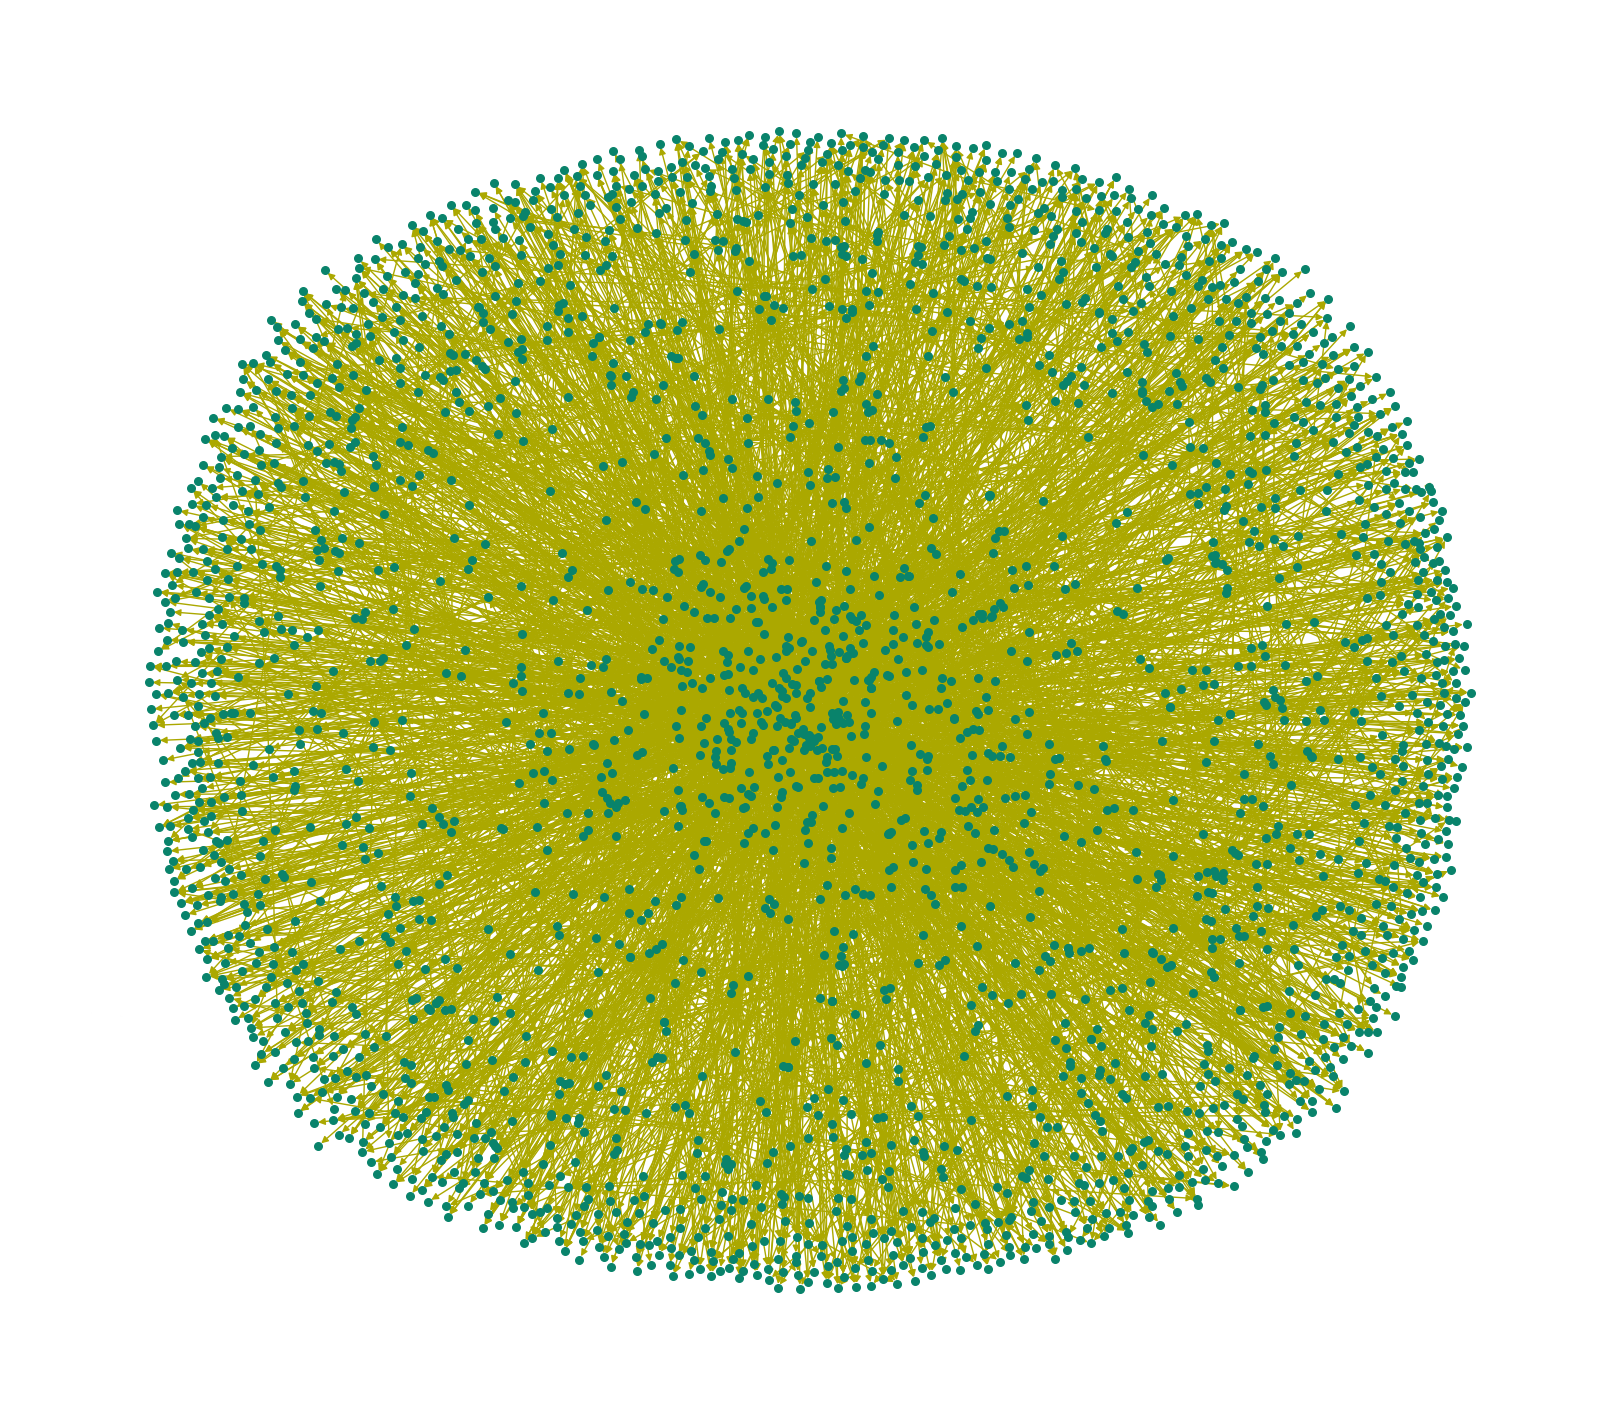

In [18]:
plt.figure(figsize=(16,14))

nx.draw(cora, 
        node_size=30, 
        edge_color="#ABA800", 
        node_color="#09836B", 
        with_labels=False,
        font_size=10)

plt.show()

In [19]:
# We can also retrieve the node labels subject
cora_meta = os.path.expanduser(os.path.join(data_loc, "cora.content"))
node_attr = pd.read_csv(cora_meta, sep='\t', header=None)
values = { row.tolist()[0]: row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(cora, values, 'subject')

In [20]:
print(tabulate([[np.unique(np.array(list(values.values())), return_counts=True)[0][i],
                 np.unique(np.array(list(values.values())), return_counts=True)[1][i]]
                for i in range(7)], 
               headers=["labels", 'count']))

labels                    count
----------------------  -------
Case_Based                  298
Genetic_Algorithms          418
Neural_Networks             818
Probabilistic_Methods       426
Reinforcement_Learning      217
Rule_Learning               180
Theory                      351


#### Ready to describe the network 

We will follow the same steps as for scikit-network to describe the graph. Le networkx library offers more straighforward functions to obtain these caracteristics. 

In [21]:
print("Number of nodes: ", cora.number_of_nodes())
print("Number of edges: ", cora.number_of_edges())

Number of nodes:  2708
Number of edges:  5429


The density of a directed graph is :

$$ d = \frac{m}{n.(n-1)} $$

where n is the number of nodes and m is the number of edges in G.

In [22]:
print("Density of the graph: ", nx.density(cora))

Density of the graph:  0.0007405986667314184


A directed graph is strongly connected if and only if every vertex in the graph is reachable from every other vertex.

A directed graph is weakly connected if and only if the graph is connected when the direction of the edge between nodes is ignored.

A directed graph is semiconnected if, and only if, for any pair of nodes, either one is reachable from the other, or they are mutually reachable.

In [23]:
print("Strongly connected graph ? ", nx.is_strongly_connected(cora))
print("Weakly connected graph ? ", nx.is_weakly_connected(cora))
print("Semiconnected graph ? ", nx.is_semiconnected(cora))

Strongly connected graph ?  False
Weakly connected graph ?  False
Semiconnected graph ?  False


Equivalently, a strongly connected component of a directed graph G is a subgraph that is strongly connected, and a weakly connected component is a subgraph that is weakly connected.

In [24]:
print("Number of strongly connected components in the graph: ", nx.number_strongly_connected_components(cora))
print("Number of weakly connected components in the graph: ", nx.number_weakly_connected_components(cora))

Number of strongly connected components in the graph:  2526
Number of weakly connected components in the graph:  78


In [25]:
# We can also compute the degree of each node 
outdeg_cora = cora.out_degree()
indeg_cora = cora.in_degree()
deg_cora = cora.degree()

**To do**: check what is the type of deg_cora, then write a function to get the average degree of a graph 

In [26]:
type(deg_cora)

networkx.classes.reportviews.DiDegreeView

In [27]:
def average_degree(G):
    # to do
    sum_degree = sum(dict(G.degree()).values())
    avg_degree = sum_degree / G.number_of_nodes()
    return avg_degree

In [28]:
average_degree(cora)

4.0096011816839

In [29]:
# Centrality measures 

## eigenvectors 
c_eig = nx.eigenvector_centrality(cora)

## closeness 
c_clo = nx.closeness_centrality(cora)

## betweeness 
c_bet = nx.betweenness_centrality(cora)

<b>Closeness centrality</b> scores each node based on their ‘closeness’ to all other nodes in the
network. Nodes that are able to reach other nodes via short paths, or who are “more
reachable” by other nodes via shorter paths, are in more favoured positions. Such nodes are
“central” to the network as they can reach the whole network more quickly than non-central
nodes. This structural advantage can be translated into power, and it leads to the notion
of closeness centrality. It is the inverse of the average distance from a given starting node to
all other nodes in the network. It is used to find the individuals who are best placed to
influence the entire network most quickly

$$ \text{closeness_centrality(i)} = \frac{n-1}{\sum_{j=1}^{n}d(i,j)} $$

<b>Betweenness centrality</b> measures the number of times a node lies on the shortest path
between other nodes. This measure shows which nodes are ‘bridges’ between nodes in a
network. It does this by identifying all the shortest paths and then counting how many times
each node falls on one. It is used to find the individuals who influence the flow around a
system. For each pair of nodes in a social network, consider one of the shortest paths- all
nodes in this path are intermediaries. The node that belongs to the shortest paths between
the maximum number of such communications, is a special node — it is a potential deal maker
and is in a special position since most other nodes have to channel their communications
through it. Such a node has a high betweenness centrality.

$$ \text{betweenness_centrality(i)} = \sum_{i≠j≠k}\frac{n_{jk}(i)}{n_{jk}} $$
<br>where $n_{jk}$ is the total number of shortest paths from node $j$ to $k$ and $n_{jk}(i)$ is the number of those paths that pass through $i$.

<b>Eigenvector centrality</b> measures a node’s influence based on the number of
links it has to other nodes in the network. EigenCentrality then goes a step further by also
taking into account how well connected a node is, and how many links their connections have,
and so on through the network. By calculating the extended connections of a node, Eigen
centrality can identify nodes with influence over the whole network, not just those directly
connected to it. A high Eigen centrality score means that a node is connected to many nodes
who themselves have high scores.

Let $A = (a_{ij})$ be the adjacency matrix where $a_{ij}=1$ if there is an edge from node $i$ to node $j$ and $a_{ij}=0$ otherwise, and $λ$ be the largest eigenvalue of $A$ with eigenvector $v$ : $A.v = λ.v$. The eigenvector centrality of a node $i$ is the entry $v_i$ of the eigenvector $v$.

**To do** For each centrality measure and degree get the top-5 most important nodes. What do you observe?

In [30]:
df_c_eig = pd.DataFrame.from_dict(dict(c_eig), orient='index')
df_c_eig.reset_index(inplace=True)
df_c_eig.columns = ('node', 'eigenvector centrality')
df_c_eig = df_c_eig.sort_values('eigenvector centrality', ascending=False).reset_index(drop=True)
df_c_eig.head()

node  eigenvector centrality
0  126927                0.484800
1  103543                0.392399
2  645897                0.359191
3  644093                0.291532
4  646286                0.285262

In [31]:
df_c_clo = pd.DataFrame.from_dict(dict(c_clo), orient='index')
df_c_clo.reset_index(inplace=True)
df_c_clo.columns = ('node', 'closeness centrality')
df_c_clo = df_c_clo.sort_values('closeness centrality', ascending=False).reset_index(drop=True)
df_c_clo.head()

node  closeness centrality
0  1107067              0.007026
1  1153811              0.006847
2    66982              0.006839
3    39210              0.006743
4  1050679              0.006692

In [32]:
df_c_bet = pd.DataFrame.from_dict(dict(c_bet), orient='index')
df_c_bet.reset_index(inplace=True)
df_c_bet.columns = ('node', 'betweeness centrality')
df_c_bet = df_c_bet.sort_values('betweeness centrality', ascending=False).reset_index(drop=True)
df_c_bet.head()

node  betweeness centrality
0   1272               0.001300
1  13686               0.001225
2   6184               0.001166
3  85688               0.000993
4    887               0.000984

In [33]:
df_out_degree = pd.DataFrame.from_dict(dict(outdeg_cora), orient='index')
df_out_degree.reset_index(inplace=True)
df_out_degree.columns = ('node', 'out-degree')
df_out_degree = df_out_degree.sort_values('out-degree', ascending=False).reset_index(drop=True)
df_out_degree.head()

node  out-degree
0    35         166
1  6213          76
2  1365          74
3  3229          61
4   114          42

In [34]:
df_in_degree = pd.DataFrame.from_dict(dict(indeg_cora), orient='index')
df_in_degree.reset_index(inplace=True)
df_in_degree.columns = ('node', 'in-degree')
df_in_degree = df_in_degree.sort_values('in-degree', ascending=False).reset_index(drop=True)
df_in_degree.head()

node  in-degree
0    33818          5
1    28278          5
2    38480          5
3      434          5
4  1107067          5

In [35]:
df_degree = pd.DataFrame.from_dict(dict(deg_cora), orient='index')
df_degree.reset_index(inplace=True)
df_degree.columns = ('node', 'degree')
df_degree = df_degree.sort_values('degree', ascending=False).reset_index(drop=True)
df_degree.head()

node  degree
0    35     169
1  6213      79
2  1365      74
3  3229      65
4   910      46

The top-5 nodes for each centrality measure are different, as each measure captures different aspects of a node's importance or centrality in the network. The nodes that rank highly for one measure may not rank highly for another.

## Node Embedding : DeepWalk

DeepWalk is a classic baseline for node embedding, based on random walks. Basically, a random walk is a way of converting a graph into a sequence of nodes. DeepWalk consists of two main steps: 
1. For each node in the graph, generate a random path of nodes connected 
2. From the corpus of random paths generated in step 1, train a skip-gram (Word2Vec) model 

In this part, we start by implementing the random walk ourselves (for understanding purpose), then use the Word2Vec implementation provided in `gensim`. Then, you will have to find a scalable implementation of the random-walk online and apply it to the full cora network (=what you'll have to do in companies !). 

In [36]:
import random

# Convert Cora to an undirected network 
cora_u = cora.to_undirected()

### Random walk 

Our objective is to write a function, that given a graph, a specific node and the length of the walk, generate a random walk on the graph. The ouput of the function is a list of all the nodes composing the walk. To obtain the list of direct neighbors of a given node, you can use the function `all_neighbors` from the `networkx` package.

In [37]:
import random 

walkLength = 10
startNode = list(cora_u.nodes)[0]

# Initialize the walk 
walk = [str(startNode)]
current_node = startNode
for _ in range(walkLength-1):
    # List of neighbors 
    neighbors = list(nx.all_neighbors(cora_u, current_node))
    # Select a random node as the next step in the walk 
    next_node = random.choice(neighbors)
    # Add the node to the walk 
    walk.append(str(next_node))
    # Update de position of the random walk 
    current_node = next_node

# Display the obtained walk
print(walk) 

['35', '28851', '595157', '210871', '575077', '579008', '248425', '594387', '579008', '575077']


**To do** What do you observe if you run the above cell multiple times ? Why ?

When we run this cell multiple times, we notice that the resulting walk is different each time. Because the selection of next_node is random from the neighbors list and it is based on the current node, so it gives different results for each run.

#### To do 

1. Define a function random_walk containing the steps above 
2. Explain the code given below. Then based on this latter, define a function RandomWalker that perform a given number of random walks per node and output a corpus of randomwalks (test with 2 random walks per node).

In [38]:
def random_walk(g, node, wlen=10):
    # To do
    # Initialize the walk 
    walk = [str(node)]
    current_node = node
    for _ in range(wlen-1):
        # List of neighbors 
        neighbors = list(nx.all_neighbors(g, current_node))
        # Select a random node as the next step in the walk 
        next_node = random.choice(neighbors)
        # Add the node to the walk 
        walk.append(str(next_node))
        # Update de position of the random walk 
        current_node = next_node
    return walk

# Explain the code given below
walks = []
for node in cora.nodes():
    for _ in range(30):
        walks.append(random_walk(cora,node))
# This code outputs 30 random walks per node (the start node). The walks length is equal to 10 by default.

pd.DataFrame(walks)

0        1        2        3        4       5        6       7  \
0          35  1130847       35  1128985   227178   96847     6163    6220   
1          35  1129778   103515   246618   116545  578645   578845  578645   
2          35  1130856   287787  1130847       35   85352  1129027      35   
3          35   289780  1128453    87417   801170   87417   801170      35   
4          35   787016   513189    82920    81714   82920  1125492   82920   
...       ...      ...      ...      ...      ...     ...      ...     ...   
81235  853118  1140289     3229   157401  1118017  157401  1118017  157401   
81236  853118   853155   853115    19621   240791   19621     7297    7276   
81237  853118   853155   853114   853116    19621  649739  1131464   19621   
81238  853118  1140289     3229  1128868   194609  563613  1129572   31927   
81239  853118   853155   853116    19621   123825  649731     1365  120084   

             8        9  
0         6213     4584  
1       578845   593240  
2        48766    35061  
3       694759     1688  
4      1125492    82920  
...        ...      ...  
81235     1365  1114352  
81236    19621   853115  
81237   240791  1113438  
81238   563613  1129572  
81239     1365   188471  

[81240 rows x 10 columns]

In [39]:
def RandomWalker(g, wlen=10, num_walks=2):
    walks = []
    for node in g.nodes():
        for _ in range(num_walks):
            walks.append(random_walk(g, node, wlen))
    return walks

pd.DataFrame(RandomWalker(cora_u, wlen=10, num_walks=2))

0        1       2        3        4        5        6        7  \
0         35   513189  573964   787016   513189  1125597   513189  1125597   
1         35  1131360  307656   270085   307656   270085   307656  1131360   
2       1033  1107062   61069    28456    57119  1129570     8865   785678   
3       1033       35  231249  1127913   103515  1128314   579108  1128314   
4     103482  1128990   27510   103482       35   640617       35   175291   
...      ...      ...     ...      ...      ...      ...      ...      ...   
5411  853155   853116   19621     6184  1120731     6210    28489    13193   
5412  853115   853116  853114    19621  1128846    19621   853115   853155   
5413  853115   853114  853155   853115   853114    19621     6184     4584   
5414  853118  1140289  853118   853155   853114    19621  1114442    19621   
5415  853118   853155  853114    19621   123825  1131464   649739   123825   

            8        9  
0      513189   576691  
1        1688    44368  
2        8865   103515  
3      579108  1128314  
4        8617    52784  
...       ...      ...  
5411     6213    91975  
5412   853114   853116  
5413    13885    90888  
5414  1135137     1365  
5415    19621    66990  

[5416 rows x 10 columns]

### Word2Vec 



In [40]:
# Install the library 
# !pip install gensim

In [41]:
from gensim.models import Word2Vec

In [42]:
# Initialise the model 
embedder = Word2Vec(
    window = 3, ## Maximum distance between the current and predicted word within a sentence.
    seed=42, ## Seed for the random number generator.
    sg=1, ## Training algorithm: 1 for skip-gram; otherwise CBOW.
    vector_size=32, ## Dimensionality of the word vectors.
    hs=0, ## If 1, hierarchical softmax will be used for model training. 
          ## If 0, and negative is non-zero, negative sampling will be used.
    negative=10, ## If > 0, negative sampling will be used. This parameter specifies how many “noise words” should be drawn.
                 ## If set to 0, no negative sampling is used.
    alpha=0.02, ## The initial learning rate.
    min_alpha=0.0001, ## Learning rate will linearly drop to min_alpha as training progresses.
)

**To do** : take a look at all the hyper-parameters and check for their meaning in the documentation. 
Write in comments their role in the cell above. 

➤ <b>window</b> : Maximum distance between the current and predicted word within a sentence.
<br>➤ <b>seed</b> : Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed).
<br>➤ <b>sg</b> : Training algorithm: 1 for skip-gram; otherwise CBOW.
<br>➤ <b>vector_size</b> : Dimensionality of the word vectors.
<br>➤ <b>hs</b> : If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
<br>➤ <b>negative</b> : If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
<br>➤ <b>alpha</b> : The initial learning rate.
<br>➤ <b>min_alpha</b> : Learning rate will linearly drop to min_alpha as training progresses.

We will use <b>skip-gram</b> as our training algorithm. the skip-gram model takes one word as input and predicts its closely related context words. We will also use <b>negative sampling</b> as our loss function.

In [43]:
# Next, we build the vocabulary out of the nodes 
embedder.build_vocab(walks,progress_per=2) 
## walks = list of random walks ; progress_per = Indicates how many nodes to process before showing/updating the progress.
embedder.train(
    walks,
    total_examples=embedder.corpus_count, ## Number of random walks = 81240
    epochs=4, ## An epoch means one complete pass of the training dataset through the algorithm.
)

vectors = pd.DataFrame({node: embedder.wv[node] for node in embedder.wv.key_to_index.keys()}).T

**To do** : display the shape of embedding matrix and the 3 first rows. 

In [44]:
print("The shape of embedding matrix: ", vectors.shape)

The shape of embedding matrix:  (2708, 32)


2708 = Number of nodes
<br>32 = Dimensionality of the word vectors
<br>➜ The embedding vector of the node $v_{i}$ is the $i^{th}$ row in our embedding matrix.

In [45]:
# The 3 first rows in our embedding matrix
vectors.iloc[:3,:]

0         1         2         3         4         5         6   \
35   -0.454829  1.084758  0.026070 -0.618848 -0.327275  0.542898 -0.620025   
1365 -0.760632  0.889089 -0.262031 -0.499385  0.803664  1.577343 -0.655588   
3229 -0.513392 -0.232233  0.537720 -1.099087  0.193653  0.586569  0.920685   

            7         8         9   ...        22        23        24  \
35   -0.305748 -0.434612 -0.667590  ... -0.032977  0.239586  0.242470   
1365 -0.278393 -0.274816 -0.016779  ...  0.792250 -0.788322 -0.195225   
3229 -0.257126 -0.499873 -1.418471  ...  0.029488 -0.838592 -0.245966   

            25        26        27        28        29        30        31  
35    0.258808 -0.113619  0.082131  0.573188  1.544053  0.274424 -0.435334  
1365 -0.255615  0.064301  0.037797  0.142894  1.082886  0.439265  0.063624  
3229 -0.023619 -0.080587  0.411417 -0.409358  0.811047  1.033728 -0.557511  

[3 rows x 32 columns]

In [46]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [47]:
# Join embedding and label information
t = pd.DataFrame.from_dict(values, orient='index', columns=['label'])
t.index = t.index.astype(str)
h = vectors.join(t, how='left')
print(h.shape)
h.head()

(2708, 33)


0         1         2         3         4         5         6  \
35   -0.454829  1.084758  0.026070 -0.618848 -0.327275  0.542898 -0.620025   
1365 -0.760632  0.889089 -0.262031 -0.499385  0.803664  1.577343 -0.655588   
3229 -0.513392 -0.232233  0.537720 -1.099087  0.193653  0.586569  0.920685   
6213 -0.891798  0.346616 -0.296516 -0.879426  0.119313 -0.297626  0.617046   
910  -1.694797  0.753261  0.183499  0.033369  0.139710  0.955878  0.344024   

             7         8         9  ...        23        24        25  \
35   -0.305748 -0.434612 -0.667590  ...  0.239586  0.242470  0.258808   
1365 -0.278393 -0.274816 -0.016779  ... -0.788322 -0.195225 -0.255615   
3229 -0.257126 -0.499873 -1.418471  ... -0.838592 -0.245966 -0.023619   
6213 -0.812206 -0.370122  0.480102  ... -0.826351  0.727300 -0.327626   
910  -0.025554 -0.607667 -1.212972  ... -0.657526  0.513889 -1.124184   

            26        27        28        29        30        31  \
35   -0.113619  0.082131  0.573188  1.544053  0.274424 -0.435334   
1365  0.064301  0.037797  0.142894  1.082886  0.439265  0.063624   
3229 -0.080587  0.411417 -0.409358  0.811047  1.033728 -0.557511   
6213 -0.391806  0.036898  0.458146  0.762890  0.445193 -0.554057   
910  -0.319292  0.753629  0.030822  1.049563 -0.456372 -0.070431   

                       label  
35        Genetic_Algorithms  
1365         Neural_Networks  
3229         Neural_Networks  
6213  Reinforcement_Learning  
910          Neural_Networks  

[5 rows x 33 columns]

In [48]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_vectors = tsne_model.fit_transform(h.iloc[:,:-1])

**To do** : check the dimension of tsne_vectors and take a look at the documentation of TSNE to explain the hyper-parameters.

➤ <b>perplexity</b> : The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. The perplexity must be less that the number of samples.

➤ <b>n_components</b> : Dimension of the embedded space.

➤ <b>init</b> <i>{“random”, “pca”} or ndarray of shape (n_samples, n_components)</i> : Initialization of embedding. PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

➤ <b>n_iter</b> : Maximum number of iterations for the optimization. Should be at least 250.

➤ <b>random_state</b> : Determines the random number generator.

In [49]:
print("The shape of the embedded space:", tsne_vectors.shape)

The shape of the embedded space: (2708, 2)


2708 = Number of nodes
<br>2 = Number of components
<br>➜ The coordinates of the node $v_{i}$ in the embedded space are the $i^{th}$ row in our tsne_vectors matrix.

In [50]:
# The 3 first rows in our tsne_vectors matrix
tsne_vectors[:3]

array([[-22.27784 ,  44.709244],
       [-35.3006  , -24.322338],
       [-25.806831, -19.623646]], dtype=float32)

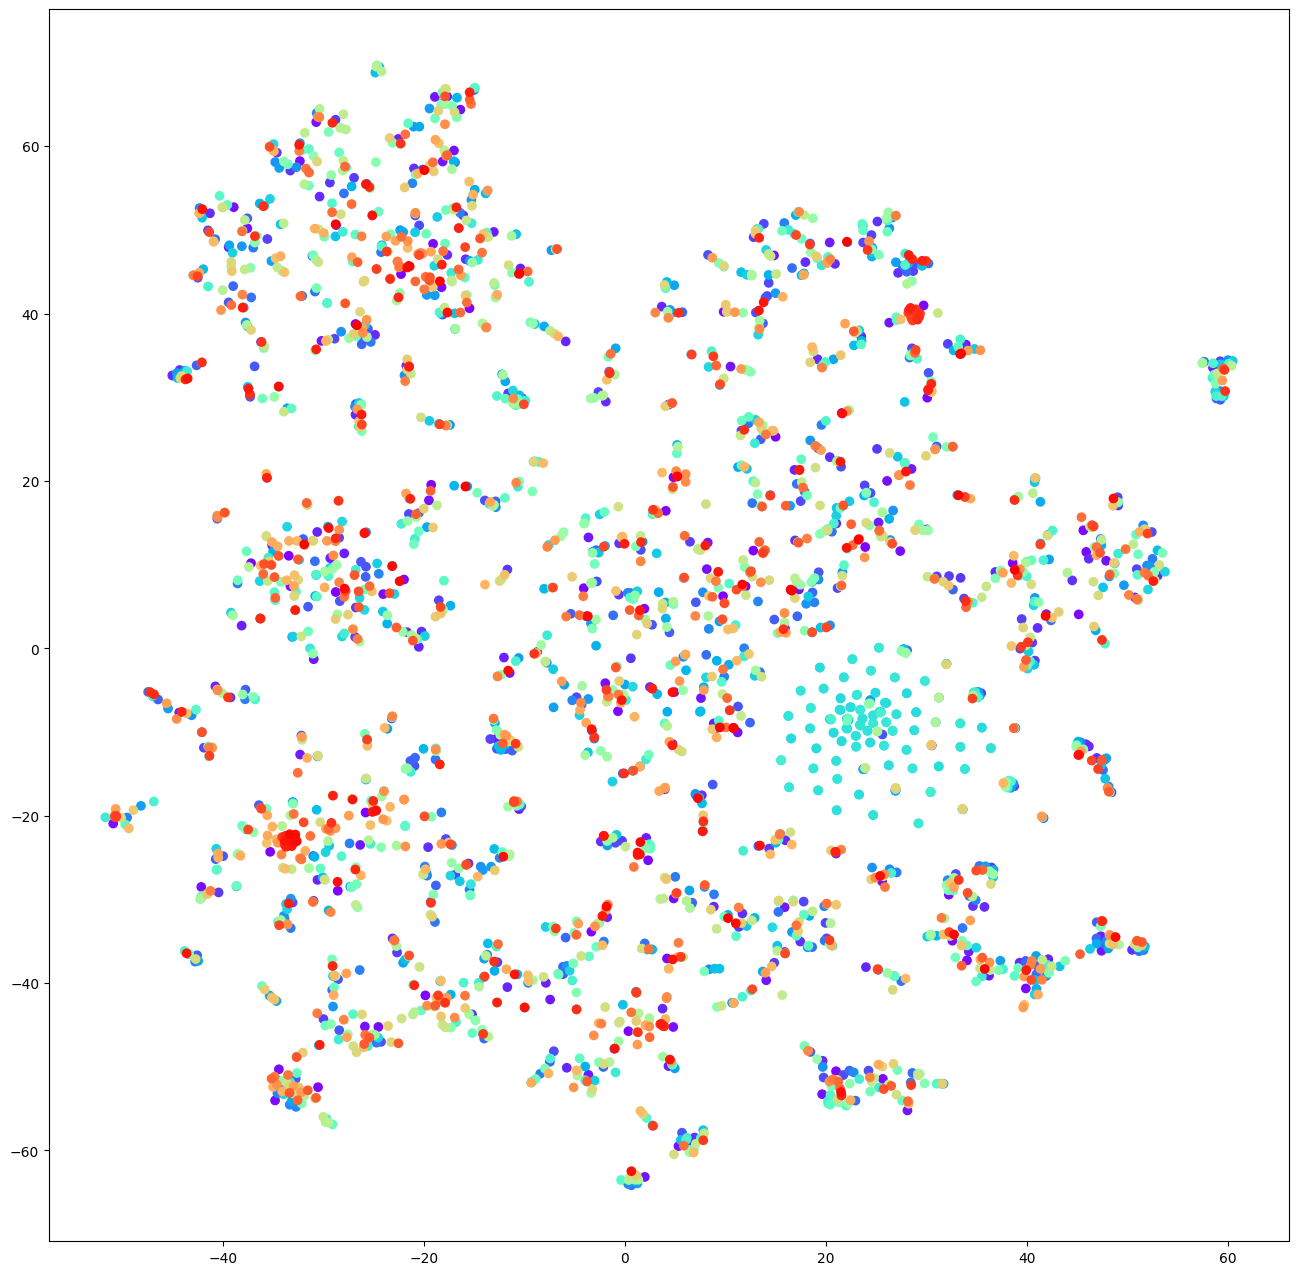

In [51]:
# Plot 
x = tsne_vectors[:,0]
y = tsne_vectors[:,1]

# Retrieve labels for visualisation 
labels = h.iloc[:,-1:]
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, label=labels, c=colors)
plt.show()

### To do 

1. Code improvement: define a class DeepWalk, which given a graph, the walk length, the number of walks per nodes and the desired dimension outputs the dataframe (or any object of your choice) of the embeddings. An option must allow to choose to visualize the obtained embedding with t-sne.

2. Use the obtained vectors as input data to learn a classifier (of your choice) to predict the **subject** of a paper. Note that, in our case we are only using the position of the paper in the graph and not the node features. 

3. Run Node2Vec on the same data and compare the obtained visualization and a classifier. You can choose the implementation/tool/librairy of your choice, but you have to specify all your sources and to carefully comment your code. 

##### Question 1 :

In [52]:
class DeepWalk:
    def __init__(self, G, vector_size, label_attribute, wlen=10, n_walks=2):
        self.graph = G
        self.nodes = list(G.nodes)
        self.edges = list(G.edges)
        self.walk_length = wlen
        self.num_walks_per_node = n_walks
        self.vector_size = vector_size
        self.desired_dimension = (len(list(G.nodes)) , vector_size+1) # 1 for the label
        self.label_attribute = label_attribute
        
    # The 'RandomWalker' function below performs n_walks random walks (of length wlen) per node
    def RandomWalker(self):
        
        def random_walk(g, node, wlen):
            walk = [str(node)]
            current_node = node
            for _ in range(wlen-1):
                neighbors = list(nx.all_neighbors(g, current_node))
                next_node = random.choice(neighbors)
                walk.append(str(next_node))
                current_node = next_node
            return walk
    
        walks = []
        for node in self.graph.nodes():
            for _ in range(self.num_walks_per_node):
                walks.append(random_walk(self.graph, node, self.walk_length))
        
        self.walks = walks

        return self
    
    # The 'embedding_vectors' function below outputs the embedding vectors of our nodes, from a corpus of walks (self.walks)
    def embedding_vectors(self, w, sg, hs, neg, alpha, min_alpha, pp, ep):
        embedder = Word2Vec(window=w, 
                            seed=42, 
                            sg=sg, 
                            vector_size=self.vector_size, 
                            hs=hs, 
                            negative=neg, 
                            alpha=alpha, 
                            min_alpha=min_alpha)
        
        embedder.build_vocab(self.walks, progress_per=pp)
        embedder.train(self.walks, total_examples=embedder.corpus_count, epochs=ep)
        vectors = pd.DataFrame({node: embedder.wv[node] for node in embedder.wv.key_to_index.keys()}).T
        
        self.embedding_vectors = vectors
        
        return self

    # The 'embedding_matrix' function below outputs the embedding vectors of our nodes as well as their labels    
    def embedding_matrix(self):
        labels = nx.get_node_attributes(self.graph, self.label_attribute)
        labels = pd.DataFrame.from_dict(values, orient='index', columns=['label'])
        labels.index = labels.index.astype(str)
        matrix = self.embedding_vectors.join(labels, how='left')
        
        self.embedding_matrix = matrix
        
        return self
    
    # The 'visualize' function allows us to visualize the obtained embedding with t-sne
    def visualize(self, p, n_components, init, n_iter):
        tsne_model = TSNE(perplexity=p, n_components=n_components, init=init, n_iter=n_iter, random_state=23)
        tsne_vectors = tsne_model.fit_transform(self.embedding_matrix.iloc[:,:-1])
        self.tsne_vectors = tsne_vectors
        x = tsne_vectors[:,0]
        y = tsne_vectors[:,1]
        labels = self.embedding_matrix.iloc[:,-1:]
        colors = cm.rainbow(np.linspace(0, 1, len(labels)))
        plt.figure(figsize=(16, 16)) 
        plt.scatter(x, y, label=labels, c=colors)
        plt.show()
        
        return self

In [53]:
deepwalk = DeepWalk(cora_u, vector_size=32, label_attribute="subject", wlen=10, n_walks=30)
deepwalk.RandomWalker()
deepwalk.embedding_vectors(w=3, sg=1, hs=0, neg=10, alpha=0.02, min_alpha=0.0001, pp=2, ep=4)
deepwalk.embedding_matrix()

print("Number of nodes: ", len(deepwalk.nodes))
print("Number of edges: ", len(deepwalk.edges))
print("Walk length: ", deepwalk.walk_length)
print("Number of walks per node: ", deepwalk.num_walks_per_node)
print("The desired dimension (for the embedding matrix): ", deepwalk.desired_dimension)
print("The shape of embedding matrix (before adding the labels vector): ", deepwalk.embedding_vectors.shape)
print("The shape of embedding matrix (after adding the labels vector): ", deepwalk.embedding_matrix.shape)

Number of nodes:  2708
Number of edges:  5278
Walk length:  10
Number of walks per node:  30
The desired dimension (for the embedding matrix):  (2708, 33)
The shape of embedding matrix (before adding the labels vector):  (2708, 32)
The shape of embedding matrix (after adding the labels vector):  (2708, 33)


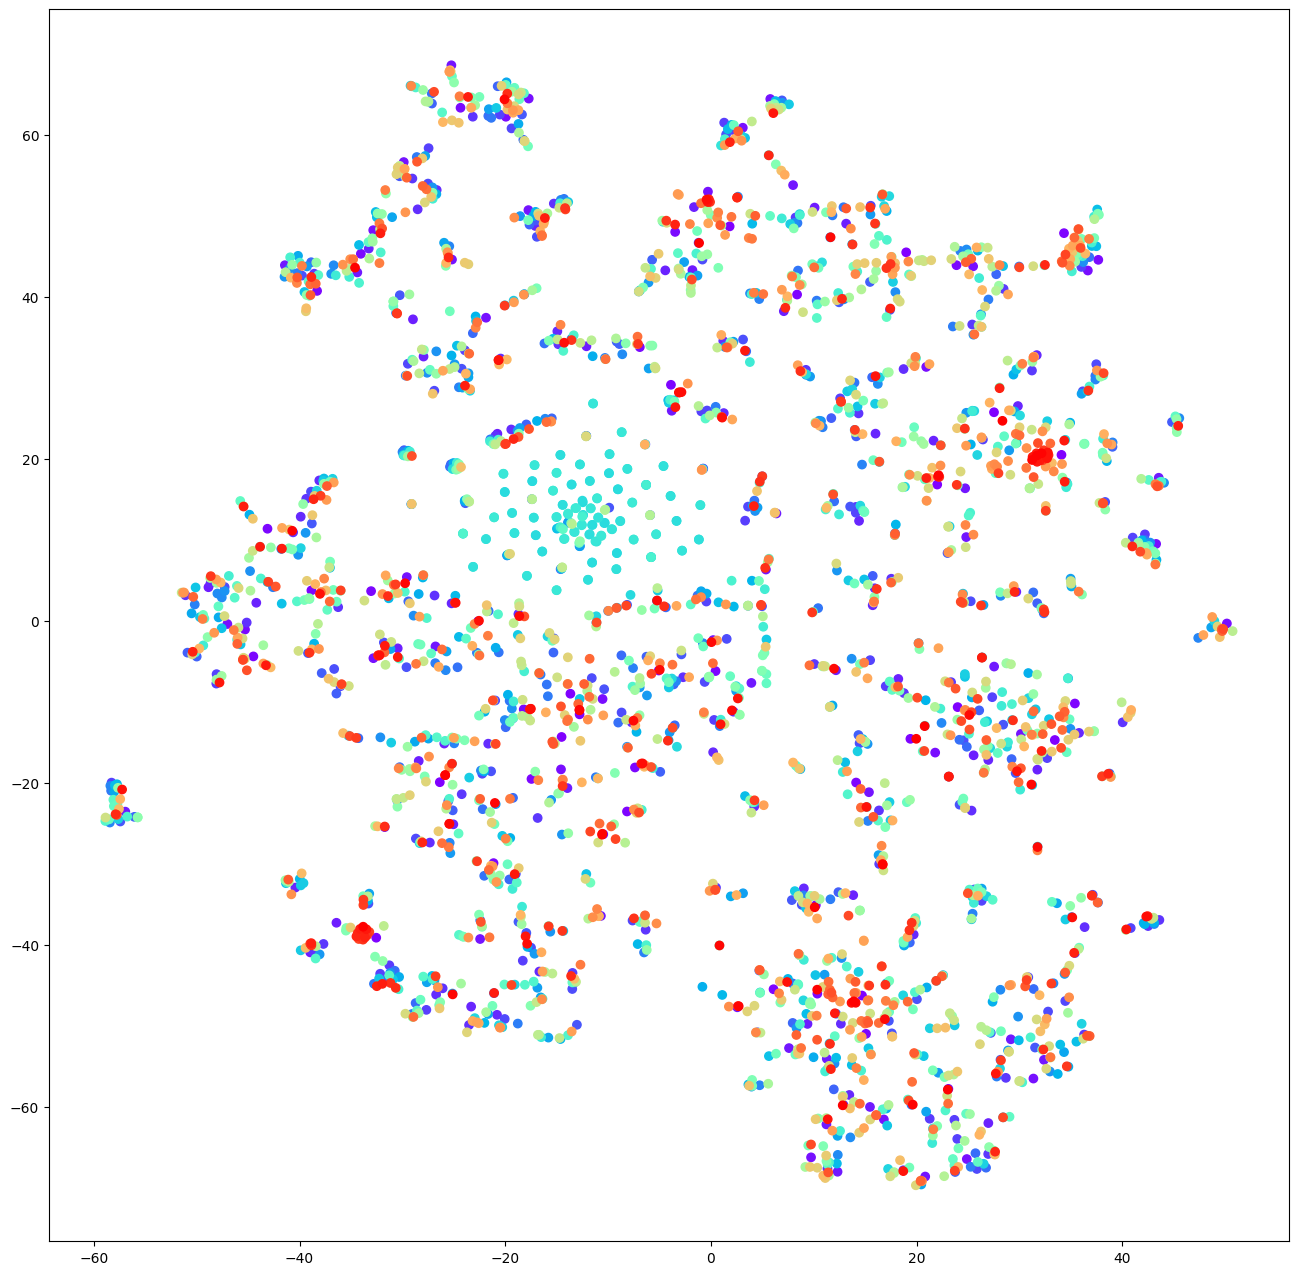

The dimension of embedded space:  (2708, 2)


In [54]:
deepwalk.visualize(p=40, n_components=2, init='pca', n_iter=2500)

print("The dimension of embedded space: ", deepwalk.tsne_vectors.shape)

##### Question 2 :

In [55]:
df = pd.DataFrame(data=deepwalk.tsne_vectors, index=deepwalk.embedding_matrix.index, columns=['X1', 'X2'])
df['Y'] = deepwalk.embedding_matrix.iloc[:,-1]

df

X1         X2                       Y
35       14.687436 -46.233692      Genetic_Algorithms
1365     34.081860  20.480402         Neural_Networks
3229     22.000723  16.815046         Neural_Networks
6213     33.435135 -14.703840  Reinforcement_Learning
910      18.985146  45.470264         Neural_Networks
...            ...        ...                     ...
1110768  -1.154347  46.619804         Neural_Networks
1152508  13.888612 -46.949535      Genetic_Algorithms
577086   10.329531 -45.511238      Genetic_Algorithms
13966    20.779774 -12.990239  Reinforcement_Learning
1071981  10.091781 -35.340778  Reinforcement_Learning

[2708 rows x 3 columns]

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We will use the obtained vectors (X1 and X2) as input data to learn two classifiers (KNN & Decision tree) in order to predict the label Y.

➣ <b>KNN :</b>

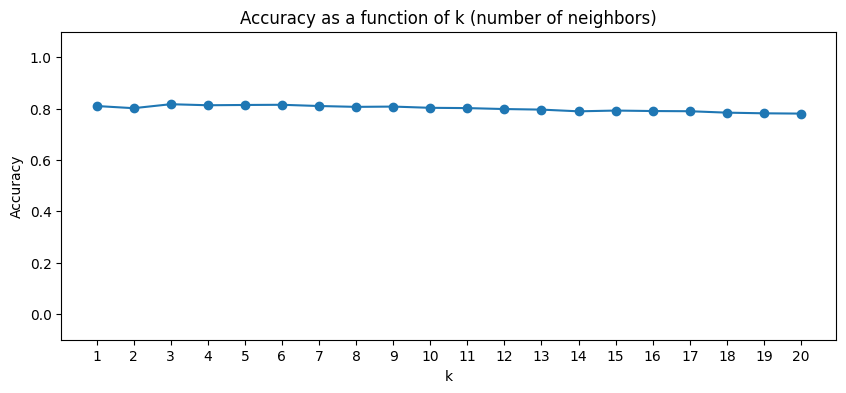

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# We select the best k (number of neighbors) using cross validation   
knn_scores = [np.mean(cross_val_score(KNeighborsClassifier(k), X, y)) for k in range(1,21)]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 4)
ax.plot(range(1,21), knn_scores, 'o-')
ax.set_title("Accuracy as a function of k (number of neighbors)")
ax.set_xlabel("k")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,21))
ax.set_ylim([-0.1, 1.1])
plt.show()

In [58]:
# The optimal value of k is the one that maximizes the accuracy
k_optimal = np.argmax(knn_scores) + 1
print("The optimal value of k is : ", k_optimal)

The optimal value of k is :  3


In [59]:
# We use this value of k to train our classifier on the train set and then we calculate the accuracy on the test set
knn = KNeighborsClassifier(k_optimal)
knn.fit(X_train, y_train)
print("KNN score (k="+str(k_optimal)+") : ", knn.score(X_test, y_test))

KNN score (k=3) :  0.8265682656826568


➣ <b>Decision tree :</b>

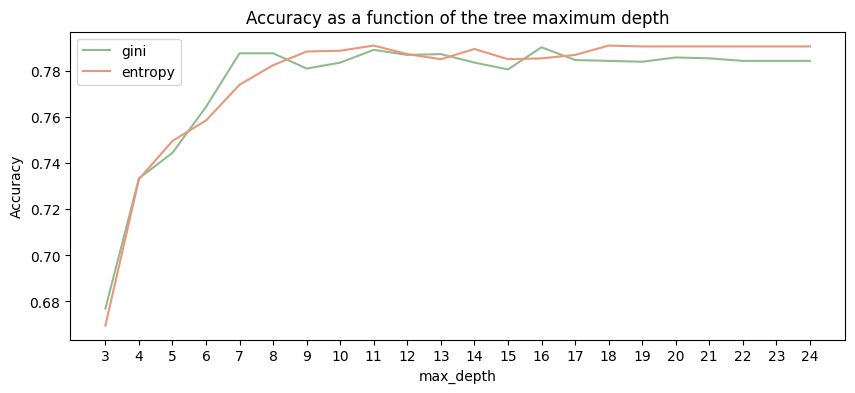

In [60]:
from sklearn.tree import DecisionTreeClassifier

# We select the best max_depth using cross validation (for both gini and entropy)   
gini_scores = [np.mean(cross_val_score(DecisionTreeClassifier(criterion="gini", max_depth=k, random_state=10), X, y)) 
               for k in range(3,25)]

entropy_scores = [np.mean(cross_val_score(DecisionTreeClassifier(criterion="entropy", max_depth=k, random_state=10), X, y)) 
                  for k in range(3,25)]

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 4)
ax.plot(range(3,25), gini_scores, '-', label='gini', color='darkseagreen')
ax.plot(range(3,25), entropy_scores, '-', label='entropy', color='darksalmon')
ax.set_title("Accuracy as a function of the tree maximum depth")
ax.set_xlabel("max_depth")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(3,25))
plt.legend(loc='upper left')
plt.show()

In [61]:
max_depth_optimal_gini = np.argmax(gini_scores) + 3
max_depth_optimal_entropy = np.argmax(entropy_scores) + 3
print("The optimal value of max_depth (Gini) : ", max_depth_optimal_gini)
print("The optimal value of max_depth (Entropy) : ", max_depth_optimal_entropy)

The optimal value of max_depth (Gini) :  16
The optimal value of max_depth (Entropy) :  11


In [62]:
decision_tree_gini = DecisionTreeClassifier(criterion="gini", max_depth=max_depth_optimal_gini, random_state=10)
decision_tree_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth_optimal_entropy, random_state=10)

decision_tree_gini.fit(X_train, y_train)
decision_tree_entropy.fit(X_train, y_train)

print("Gini score (max_depth="+str(max_depth_optimal_gini)+") : ", decision_tree_gini.score(X_test, y_test))
print("Entropy score (max_depth="+str(max_depth_optimal_entropy)+") : ", decision_tree_entropy.score(X_test, y_test))

Gini score (max_depth=16) :  0.8118081180811808
Entropy score (max_depth=11) :  0.8130381303813038


<i>Predictions</i> :

In [63]:
i = random.choice(range(len(X_test)))

print("True label :", y_test.iloc[i])
print("\nKNN prediction :", knn.predict(X_test.iloc[i].to_frame().T)[0])
print("Decision tree (Gini) prediction :", decision_tree_gini.predict(X_test.iloc[i].to_frame().T)[0])
print("Decision tree (Entropy) prediction :", decision_tree_entropy.predict(X_test.iloc[i].to_frame().T)[0])

True label : Theory

KNN prediction : Theory
Decision tree (Gini) prediction : Theory
Decision tree (Entropy) prediction : Theory


##### Question 3 :

<b>Node2Vec</b> is an algorithm that allows the user to map nodes in a graph G to an embedding space. Generally, the embedding space is of lower dimensions than the number of nodes in the original graph G. The algorithm tries to preserve the initial structure within the original graph. Essentially, the nodes which are similar within the graph will yield similar embeddings in the embedding space. These embedding spaces are essentially a vector corresponding to each node in the network. The graph embeddings are commonly used as input features to solve machine learning problems.

The process for <b>Node2Vec</b> is fairly simple, it begins by inputting a graph and extracting a set of random walks from the input graph. The walks can then be represented as a directed sequence of words where each node represents a word. The generated random walks are then passed into the skip-gram model. As explained above, the skip-gram model works on words and sentences, each node in the random walk can be represented as a word and the entire walk can be represented as a sentence. The result of the skip-gram model yields an embedding for each node (or word in this analogy). 

The entire process can be seen below :

<img src="https://miro.medium.com/max/828/1*ok8syTKrUC1_Qo7cFxZUeQ.webp"/>

The random walks are governed by two parameters $p$ and $q$. $p$ indicates the probability of a random walk getting back to the previous node, and $q$ indicates the probability that a random walk can pass through a previously unseen part of the graph.

In the example below, after transitioning to node $v$ from $t$, the return hyperparameter $p$ and the Inout hyperparameter $q$ control the probability of a walk staying inward revisiting nodes $t$, staying close to the preceeding nodes $x_1$, or moving outward farther away $(x_2, x_3)$.

<img src="https://snap.stanford.edu/node2vec/walk.png"/>

For this task, we used the implementation in this link : https://github.com/eliorc/node2vec

To better understand the process for <b>Node2Vec</b> : https://towardsdatascience.com/node2vec-explained-db86a319e9ab

In [64]:
#pip install node2vec
from node2vec import Node2Vec

In [65]:
node2vec = Node2Vec(cora_u, ## Input graph
                    dimensions = 32, ## Embedding vectors dimensions
                    walk_length = 10, ## number of nodes in each walk
                    num_walks = 30, ## Number of walks per node
                    p = 1, ## Return hyper parameter
                    q = 1) ## Inout parameter

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.53it/s]


In [66]:
model = node2vec.fit(window=3, ## Maximum distance between the current and predicted word within a sentence
                     seed=42, ## Seed for the random number generator
                     sg=1, ## Training algorithm: 1 for skip-gram; otherwise CBOW,
                     hs=0, ## If 1, hierarchical softmax will be used for model training. 
                           ## If 0, and negative is non-zero, negative sampling will be used.
                     negative=10, ## If > 0, negative sampling will be used. 
                                  ## This parameter specifies how many “noise words” should be drawn.
                                  ## If set to 0, no negative sampling is used.
                     alpha=0.02, ## The initial learning rate.
                     min_alpha=0.0001) ## Learning rate will linearly drop to min_alpha as training progresses.

In [67]:
embedding_vectors = pd.DataFrame({node: model.wv[node] for node in model.wv.key_to_index.keys()}).T

# Join embedding and label information
t = pd.DataFrame.from_dict(nx.get_node_attributes(cora, "subject"), orient='index', columns=['label'])
t.index = t.index.astype(str)
h_node2vec = embedding_vectors.join(t, how='left')
print("Embedding matrix shape :", h_node2vec.shape)
h_node2vec

Embedding matrix shape : (2708, 33)


0         1         2         3         4         5         6  \
35      -0.458409 -0.042493  1.165982 -0.768999  0.000356  0.510362 -1.138813   
1365    -0.615375 -1.314511  0.588808 -0.485026  0.502981  0.031329  0.180146   
3229     0.355723 -0.787485  0.770326 -0.497487  0.236834  0.073343  0.982654   
6213    -0.340822 -0.765594  1.964309  0.179568  0.438141 -1.177959  0.548443   
910      0.629943 -0.638074  1.479667  0.263364  0.159863  0.368647 -0.010110   
...           ...       ...       ...       ...       ...       ...       ...   
1112026 -0.468372 -0.627494  0.814941  0.235693  0.326110 -0.066606  0.583940   
593248  -0.251572 -0.068326  0.856586 -0.674767 -0.560250  0.299945 -0.385391   
1071981 -0.427641 -0.510975  1.247579 -0.220085 -0.066153 -0.435692 -0.571595   
1115886  0.434186 -0.893779  1.482693 -0.107855  0.965964 -0.558856  0.445691   
1128846  0.441702 -0.641912  0.437970  0.194777  0.692627 -0.122607  0.008367   

                7         8         9  ...        23        24        25  \
35       0.222662 -0.608613  0.213314  ...  0.303293  1.245156 -0.484155   
1365    -0.025827 -1.099206 -0.651707  ... -0.849176  0.272043 -2.182118   
3229    -0.222293 -0.427950 -0.199433  ... -0.236880  1.182504 -0.374282   
6213     0.459003 -0.905322 -0.682908  ... -0.659088  0.644757 -0.171249   
910     -0.585860 -0.760764 -0.364630  ... -0.571972  0.907132 -0.906374   
...           ...       ...       ...  ...       ...       ...       ...   
1112026  0.707896 -0.628616 -0.170383  ...  0.388678  1.181272 -0.009257   
593248   0.093804 -0.433313  0.061623  ...  0.392214  1.412942 -0.284710   
1071981  0.281075 -0.094735 -0.058262  ... -0.467492  0.850720 -0.179061   
1115886 -0.487928 -0.439511 -0.495307  ...  0.224564  1.574164 -0.905917   
1128846  0.114052 -0.079507 -0.271429  ... -0.879379 -0.008095 -0.742694   

               26        27        28        29        30        31  \
35      -0.057239 -0.309075 -0.107948 -0.040166  0.593317  0.212498   
1365     0.043676 -0.400809  0.222663  0.419646  0.168218  0.567277   
3229    -0.345885 -0.185341 -0.279621  0.411475  1.046990  0.168034   
6213     0.732768 -0.386229  0.043139 -0.634742 -0.727690  0.952582   
910      0.078006 -0.506452  0.076701  0.677803  0.178471  0.269851   
...           ...       ...       ...       ...       ...       ...   
1112026  0.753061 -0.545139  0.774920  1.041517 -0.748789  0.955480   
593248  -0.738563 -0.850245  0.079025  0.978556  0.658832  0.863610   
1071981  0.663094 -0.972064  0.071080 -0.684822  0.406696 -0.139447   
1115886  0.225285 -0.298094  0.421256  0.229169 -0.178604  0.456103   
1128846 -0.187309 -0.798682 -0.156968  0.728651  0.007945  1.101058   

                          label  
35           Genetic_Algorithms  
1365            Neural_Networks  
3229            Neural_Networks  
6213     Reinforcement_Learning  
910             Neural_Networks  
...                         ...  
1112026         Neural_Networks  
593248       Genetic_Algorithms  
1071981  Reinforcement_Learning  
1115886  Reinforcement_Learning  
1128846         Neural_Networks  

[2708 rows x 33 columns]

In [68]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_vectors_node2vec = tsne_model.fit_transform(h_node2vec.iloc[:,:-1])

print("The shape of the embedded space:", tsne_vectors.shape)

The shape of the embedded space: (2708, 2)


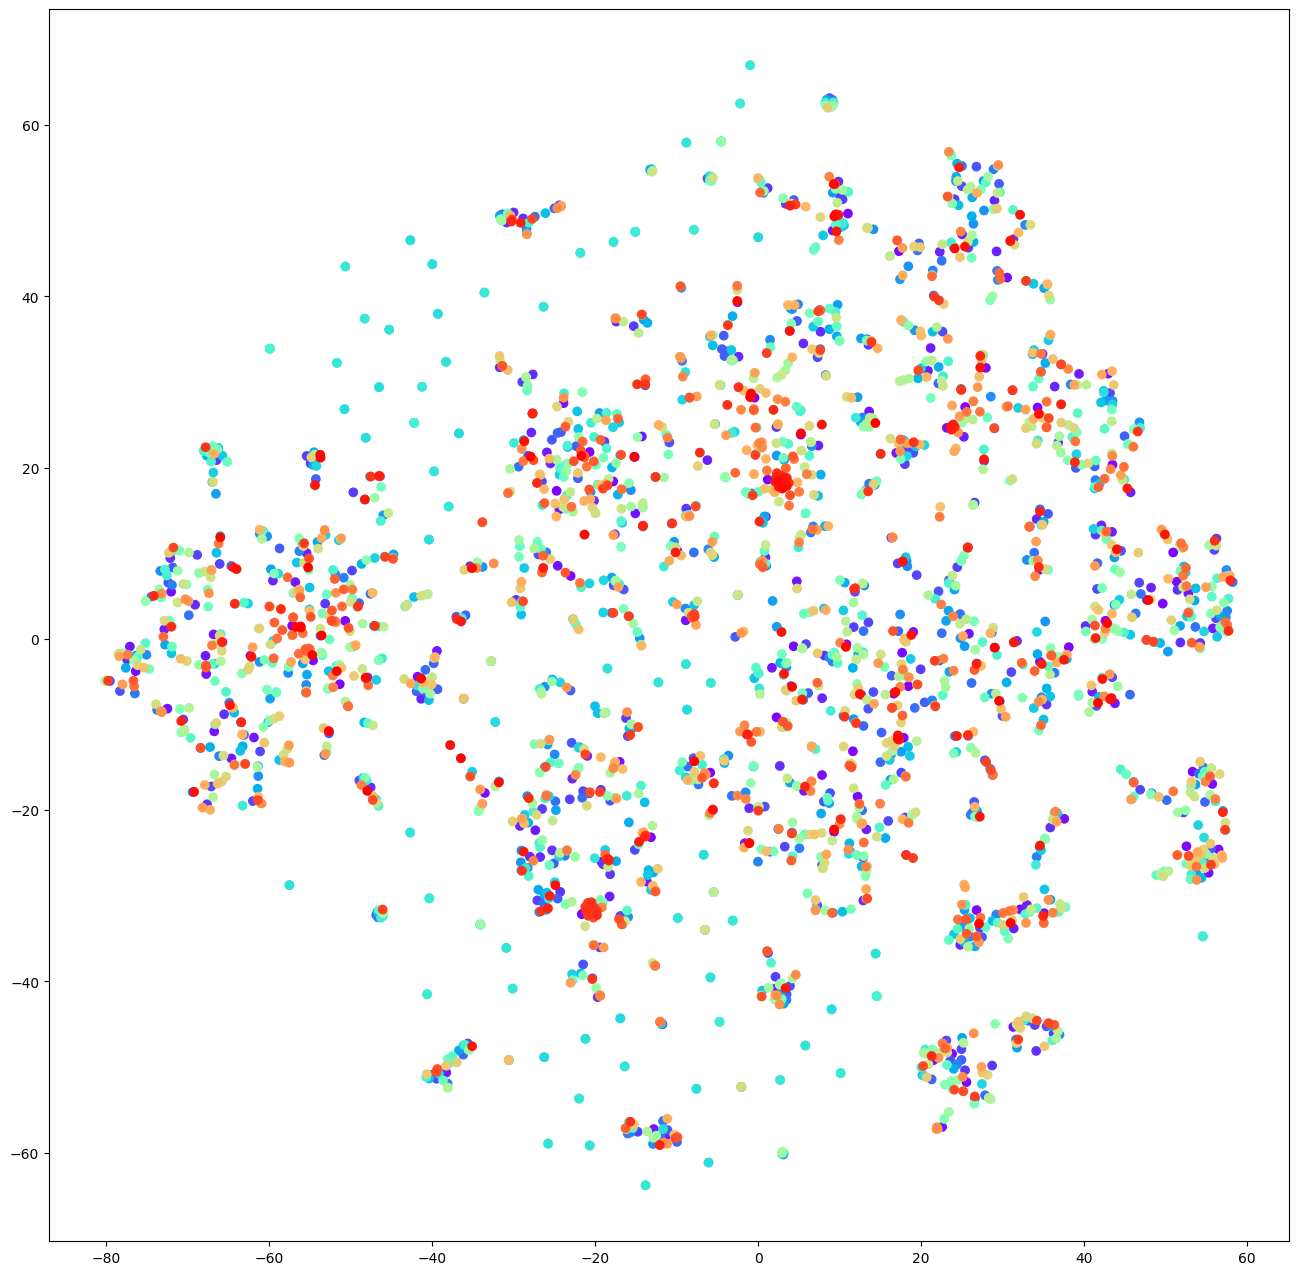

In [69]:
# Plot 
x = tsne_vectors_node2vec[:,0]
y = tsne_vectors_node2vec[:,1]

# Retrieve labels for visualisation 
labels = h_node2vec.iloc[:,-1:]
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, label=labels, c=colors)
plt.show()

We can see that this visualization is very similar to the one that we had before. Therefore, we expect to have high scores in this implementation as well.

In [70]:
df_node2vec = pd.DataFrame(data=tsne_vectors_node2vec, index=h_node2vec.index, columns=['X1', 'X2'])
df_node2vec['Y'] = h_node2vec.iloc[:,-1]

df_node2vec

X1         X2                       Y
35      -57.176090   1.537233      Genetic_Algorithms
1365      1.181161  18.610464         Neural_Networks
3229     -0.438065  28.175392         Neural_Networks
6213    -24.723539  17.300158  Reinforcement_Learning
910      34.298977  27.030603         Neural_Networks
...            ...        ...                     ...
1112026  -7.832658 -14.293495         Neural_Networks
593248  -53.571548   0.405894      Genetic_Algorithms
1071981 -41.347027  -4.622302  Reinforcement_Learning
1115886 -15.199103  21.266705  Reinforcement_Learning
1128846   5.263882  24.014641         Neural_Networks

[2708 rows x 3 columns]

In [71]:
X = df_node2vec.iloc[:,:-1]
y = df_node2vec.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

➣ <b>KNN :</b>

In [72]:
knn_scores = [np.mean(cross_val_score(KNeighborsClassifier(k), X, y)) for k in range(1,21)]

k_optimal = np.argmax(knn_scores) + 1
print("The optimal value of k is : ", k_optimal)

The optimal value of k is :  4


In [73]:
knn = KNeighborsClassifier(k_optimal)
knn.fit(X_train, y_train)
print("KNN score (k="+str(k_optimal)+") : ", knn.score(X_test, y_test))

KNN score (k=4) :  0.8142681426814268


➣ <b>Decision tree (Gini) :</b>

In [74]:
gini_scores = [np.mean(cross_val_score(DecisionTreeClassifier(criterion="gini", max_depth=k, random_state=10), X, y)) 
               for k in range(3,25)]

max_depth_optimal_gini = np.argmax(gini_scores) + 3
print("The optimal value of max_depth (Gini) : ", max_depth_optimal_gini)

The optimal value of max_depth (Gini) :  16


In [75]:
decision_tree_gini = DecisionTreeClassifier(criterion="gini", max_depth=max_depth_optimal_gini, random_state=10)
decision_tree_gini.fit(X_train, y_train)
print("Gini score (max_depth="+str(max_depth_optimal_gini)+") : ", decision_tree_gini.score(X_test, y_test))

Gini score (max_depth=16) :  0.8056580565805658


➣ <b>Decision tree (Entropy) :</b>

In [76]:
entropy_scores = [np.mean(cross_val_score(DecisionTreeClassifier(criterion="entropy", max_depth=k, random_state=10), X, y)) 
                  for k in range(3,25)]

max_depth_optimal_entropy = np.argmax(entropy_scores) + 3
print("The optimal value of max_depth (Entropy) : ", max_depth_optimal_entropy)

The optimal value of max_depth (Entropy) :  15


In [77]:
decision_tree_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth_optimal_entropy, random_state=10)
decision_tree_entropy.fit(X_train, y_train)
print("Entropy score (max_depth="+str(max_depth_optimal_entropy)+") : ", decision_tree_entropy.score(X_test, y_test))

Entropy score (max_depth=15) :  0.8167281672816729


As expected, we obtained high scores in this Node2Vec implementation.

<i>Predictions :</i>

In [78]:
i = random.choice(range(len(X_test)))

print("True label :", y_test.iloc[i])
print("\nKNN prediction :", knn.predict(X_test.iloc[i].to_frame().T)[0])
print("Decision tree (Gini) prediction :", decision_tree_gini.predict(X_test.iloc[i].to_frame().T)[0])
print("Decision tree (Entropy) prediction :", decision_tree_entropy.predict(X_test.iloc[i].to_frame().T)[0])

True label : Neural_Networks

KNN prediction : Neural_Networks
Decision tree (Gini) prediction : Theory
Decision tree (Entropy) prediction : Neural_Networks
